# Prediction Analysis for aggregated MoCo features

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

from tabular_models import get_tabular_estimator

In [2]:
import sys 
sys.path.append("..")
from training_functions import train_mocov_features, stacking_estimators
from utils import load_mocov_train_data

# Feature Selection

In [3]:
data_path=Path("../storage/")
(
    X_train,
    y_train,
    patients_train,
    samples_train,
    centers_train,
    _,
) = load_mocov_train_data(data_path=data_path, scaling="Standard", tile_averaging="pos_avg", feat_select=False)

/Users/mariastoelben/Documents/04_Studium/04_X-HEC Master 2022/M1/FS23/ENS Data Challenge/enschallenge2023/modeling/../utils.py:141: RuntimeWarning: Mean of empty slice
  features = np.nanmean(X_train[samples_train == sample], axis=0)


In [4]:
estimator = get_tabular_estimator("Catboost")
estimators_cat = train_mocov_features(
    estimator,
    X_train,
    y_train,
    patients_train,
    samples_train,
    centers_train,
    tile_avg="pos_avg",
)

AUC on split 0 validation center C_1: Train - 1.000, Val - 0.652
AUC on split 0 validation center C_2: Train - 1.000, Val - 0.688
AUC on split 0 validation center C_5: Train - 1.000, Val - 0.761
----------------------------
3-fold cross-validated AUC averaged over 1 repeats: 0.700 (0.046)


In [5]:
preds_cat = np.hstack((estimators_cat[0].predict_proba(X_train[centers_train == "C_1"])[:, 1], 
                       estimators_cat[1].predict_proba(X_train[centers_train == "C_2"])[:, 1], 
                       estimators_cat[2].predict_proba(X_train[centers_train == "C_5"])[:, 1]))

In [6]:
# create df with feature importance of classifiers
features_df = pd.DataFrame({"col": range(0, 2049)})
numbers = [1, 2, 5]
for i, lr in enumerate(estimators_cat):
    col = f"importance_C_{numbers[i]}"
    features_df[col] = lr.get_feature_importance()

In [7]:
features_df.sort_values(by="importance_C_1", ascending=False)

,col,importance_C_1,importance_C_2,importance_C_5
1788,1788,1.989483,0.060813,0.044446
289,289,1.291918,0.147705,0.086979
491,491,1.233997,0.094917,0.599018
1893,1893,0.935721,0.532007,0.494032
362,362,0.873425,0.445190,0.214896
...,...,...,...,...
1078,1078,0.000000,0.019181,0.045521
1064,1064,0.000000,0.000000,0.011060
1044,1044,0.000000,0.084618,0.029882
1035,1035,0.000000,0.000000,0.000000


In [8]:
sum(features_df["importance_C_1"] > 0.1)

191

In [9]:
sum(features_df["importance_C_2"] > 0.1)

193

In [10]:
sum(features_df["importance_C_5"] > 0.1)

214

In [11]:
# get the variables with feature importance above 0.1 for every classifier
imp_c1 = np.where(features_df["importance_C_1"] > 0.1)
imp_c2 = np.where(features_df["importance_C_2"] > 0.1)
imp_c5= np.where(features_df["importance_C_5"] > 0.1)
imps = np.hstack((imp_c1[0], imp_c2[0], imp_c5[0]))
len(set(imps))

462

# Final models

In [12]:
data_path=Path("../storage/")
(
    X_train,
    y_train,
    patients_train,
    samples_train,
    centers_train,
    _,
) = load_mocov_train_data(data_path=data_path, scaling="Standard", tile_averaging="pos_avg")

/Users/mariastoelben/Documents/04_Studium/04_X-HEC Master 2022/M1/FS23/ENS Data Challenge/enschallenge2023/modeling/../utils.py:141: RuntimeWarning: Mean of empty slice
  features = np.nanmean(X_train[samples_train == sample], axis=0)


## LogReg

In [13]:
estimator = get_tabular_estimator("LogReg")
estimators_lr = train_mocov_features(
    estimator,
    X_train,
    y_train,
    patients_train,
    samples_train,
    centers_train,
    tile_avg="pos_avg",
)

AUC on split 0 validation center C_1: Train - 1.000, Val - 0.709
AUC on split 0 validation center C_2: Train - 1.000, Val - 0.692
AUC on split 0 validation center C_5: Train - 1.000, Val - 0.813
----------------------------
3-fold cross-validated AUC averaged over 1 repeats: 0.738 (0.054)


In [14]:
preds_lr = np.hstack((estimators_lr[0].predict_proba(X_train[centers_train == "C_1"])[:, 1], 
                       estimators_lr[1].predict_proba(X_train[centers_train == "C_2"])[:, 1], 
                       estimators_lr[2].predict_proba(X_train[centers_train == "C_5"])[:, 1]))

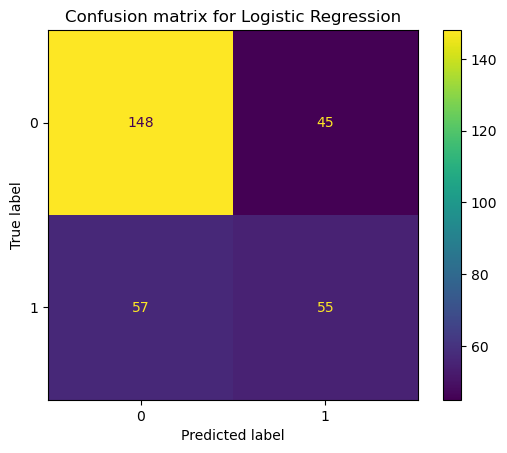

In [15]:
cm = confusion_matrix(y_train, preds_lr > 0.5)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Confusion matrix for Logistic Regression");

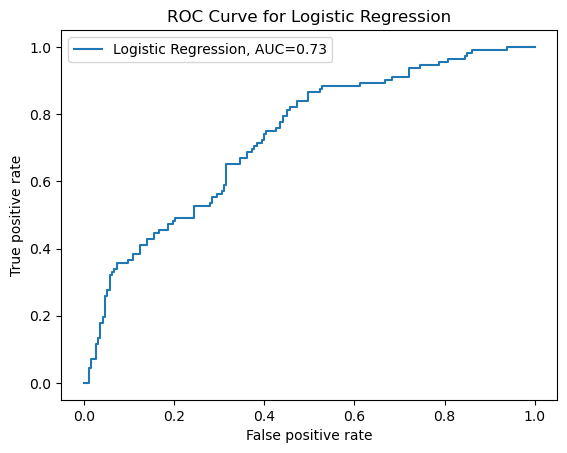

In [16]:
plt.figure(0).clf()
fpr_lr, tpr_lr, _ = roc_curve(y_train, preds_lr)
roc_auc_lr = round(roc_auc_score(y_train, preds_lr), 2)
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression, AUC=" + str(roc_auc_lr))
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC Curve for Logistic Regression");

## SVM

In [17]:
estimator = get_tabular_estimator("SVC")
estimators_svm = train_mocov_features(
    estimator,
    X_train,
    y_train,
    patients_train,
    samples_train,
    centers_train,
    tile_avg="pos_avg",
)

AUC on split 0 validation center C_1: Train - 0.995, Val - 0.729
AUC on split 0 validation center C_2: Train - 0.993, Val - 0.721
AUC on split 0 validation center C_5: Train - 0.991, Val - 0.824
----------------------------
3-fold cross-validated AUC averaged over 1 repeats: 0.758 (0.047)


In [18]:
preds_svm = np.hstack((estimators_svm[0].predict_proba(X_train[centers_train == "C_1"])[:, 1], 
                       estimators_svm[1].predict_proba(X_train[centers_train == "C_2"])[:, 1], 
                       estimators_svm[2].predict_proba(X_train[centers_train == "C_5"])[:, 1]))

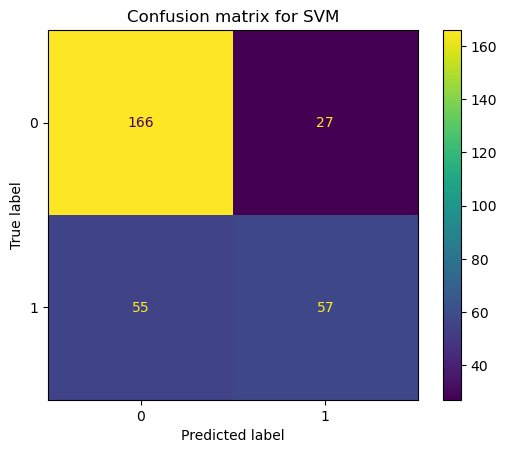

In [19]:
cm = confusion_matrix(y_train, preds_svm > 0.5)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Confusion matrix for SVM");

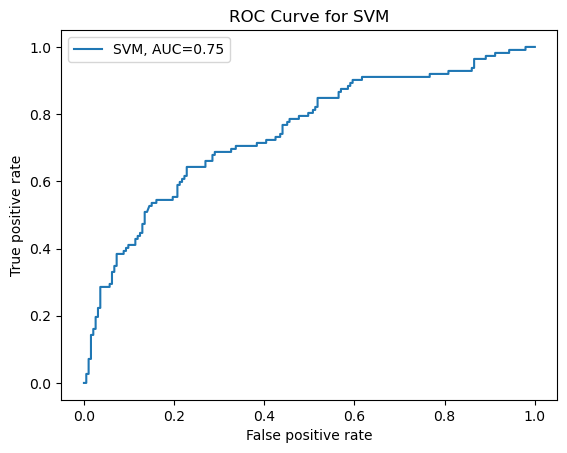

In [20]:
plt.figure(0).clf()
fpr_svm, tpr_svm, _ = roc_curve(y_train, preds_svm)
roc_auc_svm = round(roc_auc_score(y_train, preds_svm), 2)
plt.plot(fpr_svm, tpr_svm, label="SVM, AUC=" + str(roc_auc_svm))
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC Curve for SVM");

## Catboost

In [21]:
estimator = get_tabular_estimator("Catboost")
estimators_cat = train_mocov_features(
    estimator,
    X_train,
    y_train,
    patients_train,
    samples_train,
    centers_train,
    tile_avg="pos_avg",
)

AUC on split 0 validation center C_1: Train - 1.000, Val - 0.677
AUC on split 0 validation center C_2: Train - 1.000, Val - 0.733
AUC on split 0 validation center C_5: Train - 1.000, Val - 0.786
----------------------------
3-fold cross-validated AUC averaged over 1 repeats: 0.732 (0.045)


In [22]:
preds_cat = np.hstack((estimators_cat[0].predict_proba(X_train[centers_train == "C_1"])[:, 1], 
                       estimators_cat[1].predict_proba(X_train[centers_train == "C_2"])[:, 1], 
                       estimators_cat[2].predict_proba(X_train[centers_train == "C_5"])[:, 1]))

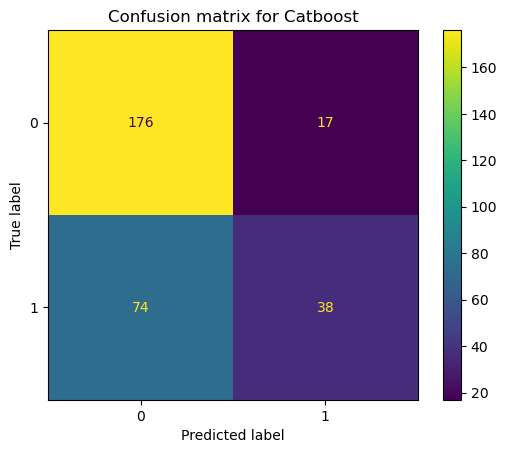

In [23]:
cm = confusion_matrix(y_train, preds_cat > 0.5)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Confusion matrix for Catboost");

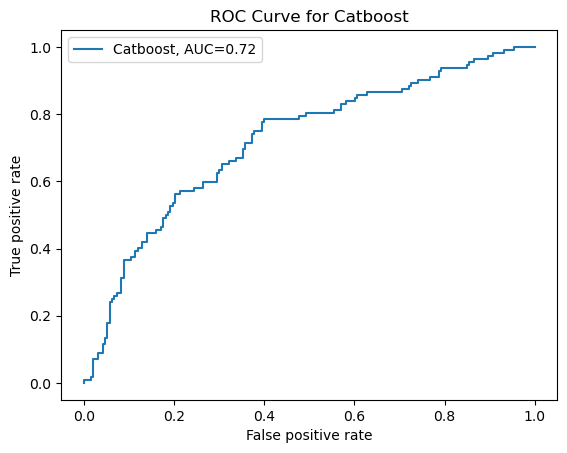

In [24]:
plt.figure(0).clf()
fpr_cat, tpr_cat, _ = roc_curve(y_train, preds_cat)
roc_auc_cat = round(roc_auc_score(y_train, preds_cat), 2)
plt.plot(fpr_cat, tpr_cat, label="Catboost, AUC=" + str(roc_auc_cat))
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC Curve for Catboost");

## Random Forest

In [25]:
estimator = get_tabular_estimator("RF")
grid = {"max_features": 1.0, "random_state": 400}
estimator.set_params(**grid)
estimators_rf = train_mocov_features(
    estimator,
    X_train,
    y_train,
    patients_train,
    samples_train,
    centers_train,
    tile_avg="pos_avg",
)

AUC on split 0 validation center C_1: Train - 1.000, Val - 0.680
AUC on split 0 validation center C_2: Train - 1.000, Val - 0.699
AUC on split 0 validation center C_5: Train - 1.000, Val - 0.726
----------------------------
3-fold cross-validated AUC averaged over 1 repeats: 0.702 (0.019)


In [26]:
preds_rf = np.hstack((estimators_rf[0].predict_proba(X_train[centers_train == "C_1"])[:, 1], 
                       estimators_rf[1].predict_proba(X_train[centers_train == "C_2"])[:, 1], 
                       estimators_rf[2].predict_proba(X_train[centers_train == "C_5"])[:, 1]))

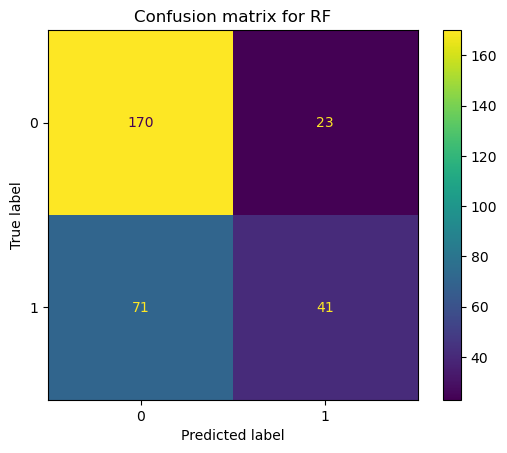

In [27]:
cm = confusion_matrix(y_train, preds_rf > 0.5)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Confusion matrix for RF");

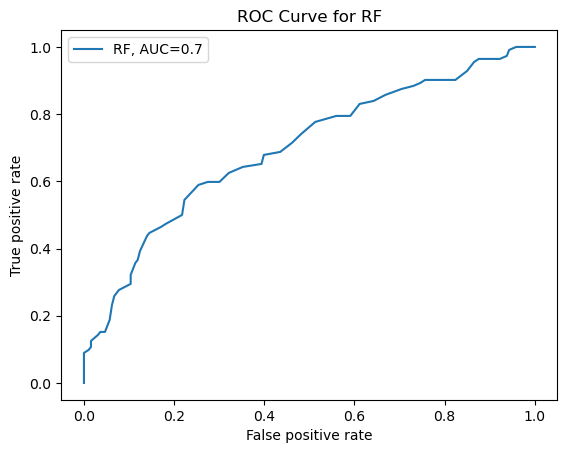

In [28]:
plt.figure(0).clf()
fpr_rf, tpr_rf, _ = roc_curve(y_train, preds_rf)
roc_auc_rf = round(roc_auc_score(y_train, preds_rf), 2)
plt.plot(fpr_rf, tpr_rf, label="RF, AUC=" + str(roc_auc_rf))
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC Curve for RF");

## LightGBM

In [29]:
estimator = get_tabular_estimator("LightGBM")
estimators_lgbbm = train_mocov_features(
    estimator,
    X_train,
    y_train,
    patients_train,
    samples_train,
    centers_train,
    tile_avg="pos_avg",
)

AUC on split 0 validation center C_1: Train - 1.000, Val - 0.609
AUC on split 0 validation center C_2: Train - 1.000, Val - 0.761
AUC on split 0 validation center C_5: Train - 1.000, Val - 0.728
----------------------------
3-fold cross-validated AUC averaged over 1 repeats: 0.699 (0.066)


In [30]:
preds_lgbm = np.hstack((estimators_lgbbm[0].predict_proba(X_train[centers_train == "C_1"])[:, 1], 
                       estimators_lgbbm[1].predict_proba(X_train[centers_train == "C_2"])[:, 1], 
                       estimators_lgbbm[2].predict_proba(X_train[centers_train == "C_5"])[:, 1]))

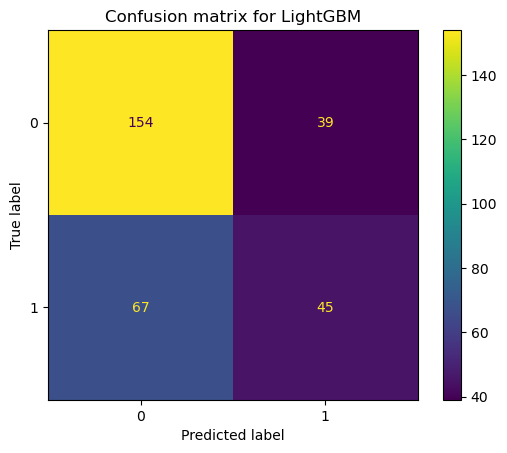

In [31]:
cm = confusion_matrix(y_train, preds_lgbm > 0.5)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Confusion matrix for LightGBM");

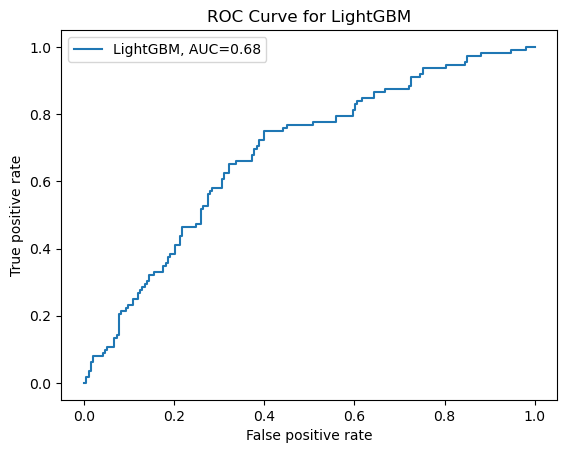

In [32]:
plt.figure(0).clf()
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_train, preds_lgbm)
roc_auc_lgbm = round(roc_auc_score(y_train, preds_lgbm), 2)
plt.plot(fpr_lgbm, tpr_lgbm, label="LightGBM, AUC=" + str(roc_auc_lgbm))
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC Curve for LightGBM");

## XGBoost

In [33]:
estimator = get_tabular_estimator("XGB")
estimators_xgb = train_mocov_features(
    estimator,
    X_train,
    y_train,
    patients_train,
    samples_train,
    centers_train,
    tile_avg="pos_avg",
)

AUC on split 0 validation center C_1: Train - 1.000, Val - 0.629
AUC on split 0 validation center C_2: Train - 1.000, Val - 0.735
AUC on split 0 validation center C_5: Train - 1.000, Val - 0.757
----------------------------
3-fold cross-validated AUC averaged over 1 repeats: 0.707 (0.056)


In [34]:
preds_xgb = np.hstack((estimators_xgb[0].predict_proba(X_train[centers_train == "C_1"])[:, 1], 
                       estimators_xgb[1].predict_proba(X_train[centers_train == "C_2"])[:, 1], 
                       estimators_xgb[2].predict_proba(X_train[centers_train == "C_5"])[:, 1]))

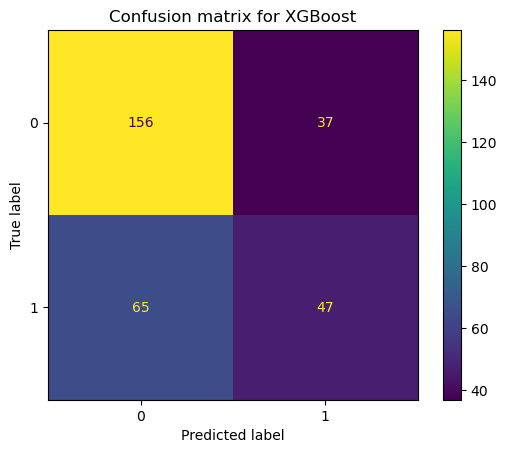

In [35]:
cm = confusion_matrix(y_train, preds_xgb > 0.5)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Confusion matrix for XGBoost");

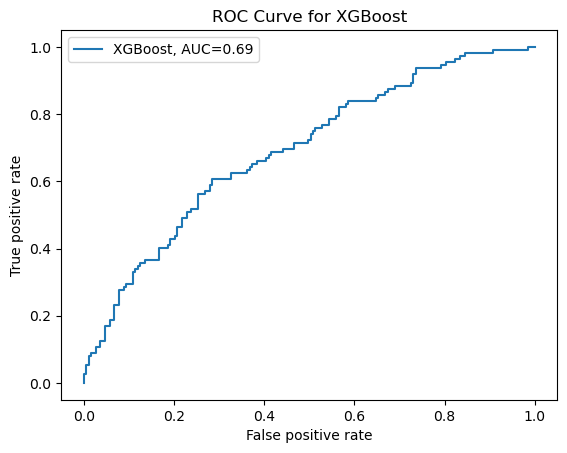

In [36]:
plt.figure(0).clf()
fpr_xgb, tpr_xgb, _ = roc_curve(y_train, preds_xgb)
roc_auc_xgb = round(roc_auc_score(y_train, preds_xgb), 2)
plt.plot(fpr_xgb, tpr_xgb, label="XGBoost, AUC=" + str(roc_auc_xgb))
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC Curve for XGBoost");

## Extra Trees

In [37]:
estimator = get_tabular_estimator("ExtraTrees")
grid = {"max_features": 1.0}
estimator.set_params(**grid)
estimators_et = train_mocov_features(
    estimator,
    X_train,
    y_train,
    patients_train,
    samples_train,
    centers_train,
    tile_avg="pos_avg",
)

AUC on split 0 validation center C_1: Train - 1.000, Val - 0.668
AUC on split 0 validation center C_2: Train - 1.000, Val - 0.705
AUC on split 0 validation center C_5: Train - 1.000, Val - 0.789
----------------------------
3-fold cross-validated AUC averaged over 1 repeats: 0.721 (0.050)


In [38]:
preds_et = np.hstack((estimators_et[0].predict_proba(X_train[centers_train == "C_1"])[:, 1], 
                       estimators_et[1].predict_proba(X_train[centers_train == "C_2"])[:, 1], 
                       estimators_et[2].predict_proba(X_train[centers_train == "C_5"])[:, 1]))

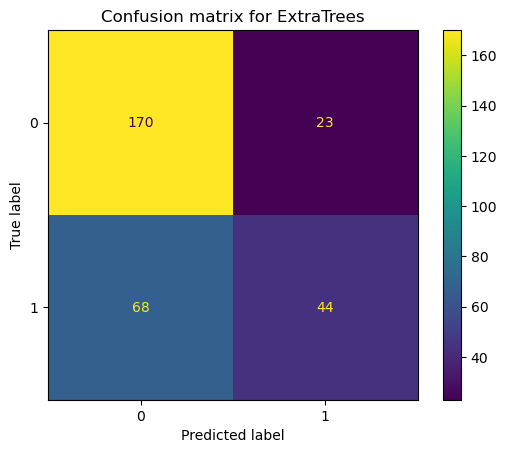

In [39]:
cm = confusion_matrix(y_train, preds_et > 0.5)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Confusion matrix for ExtraTrees");

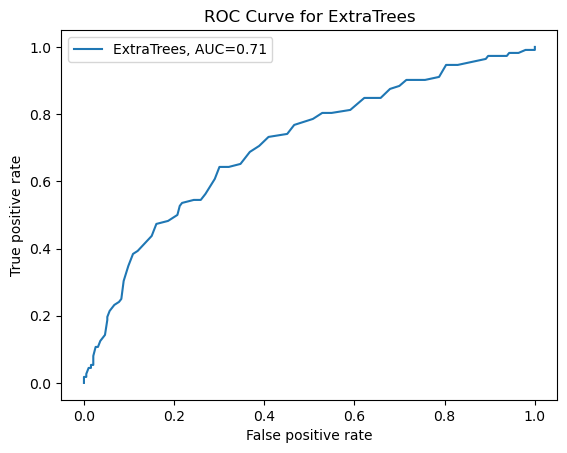

In [40]:
plt.figure(0).clf()
fpr_et, tpr_et, _ = roc_curve(y_train, preds_et)
roc_auc_et = round(roc_auc_score(y_train, preds_et), 2)
plt.plot(fpr_et, tpr_et, label="ExtraTrees, AUC=" + str(roc_auc_et))
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC Curve for ExtraTrees");

## Stacking

In [42]:
models = ["RF", "SVC", "Catboost"]
stacking = stacking_estimators(
    models,
    tile_avg="pos_avg",
    scaling="Standard",
    drop=True,
    data_path=data_path,
)

/Users/mariastoelben/Documents/04_Studium/04_X-HEC Master 2022/M1/FS23/ENS Data Challenge/enschallenge2023/modeling/../utils.py:141: RuntimeWarning: Mean of empty slice
  features = np.nanmean(X_train[samples_train == sample], axis=0)


AUC validation center C_1: Val - 0.734
AUC validation center C_2: Val - 0.747
AUC validation center C_5: Val - 0.799
----------------------------
3-fold cross-validated AUC averaged: 0.760 (0.028)


In [43]:
preds_stack = np.hstack((stacking[0].predict_proba(X_train[centers_train == "C_1"])[:, 1], 
                       stacking[1].predict_proba(X_train[centers_train == "C_2"])[:, 1], 
                       stacking[2].predict_proba(X_train[centers_train == "C_5"])[:, 1]))

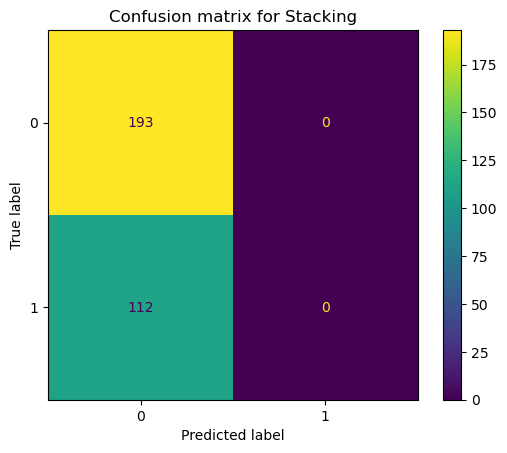

In [44]:
cm = confusion_matrix(y_train, preds_stack > 0.5)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Confusion matrix for Stacking");

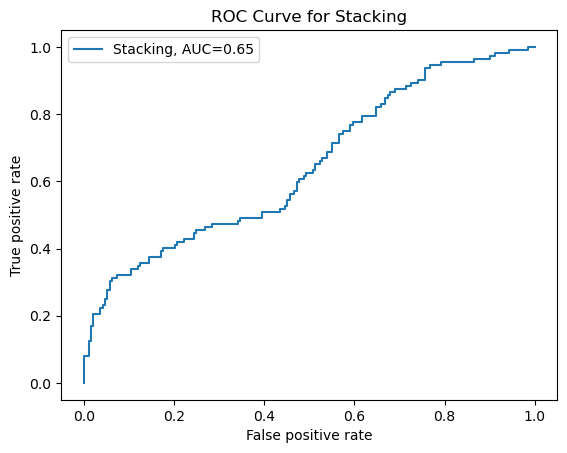

In [45]:
plt.figure(0).clf()
fpr_stack, tpr_stack, _ = roc_curve(y_train, preds_stack)
roc_auc_stack = round(roc_auc_score(y_train, preds_stack), 2)
plt.plot(fpr_stack, tpr_stack, label="Stacking, AUC=" + str(roc_auc_stack))
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC Curve for Stacking");

# Plot all ROC curves

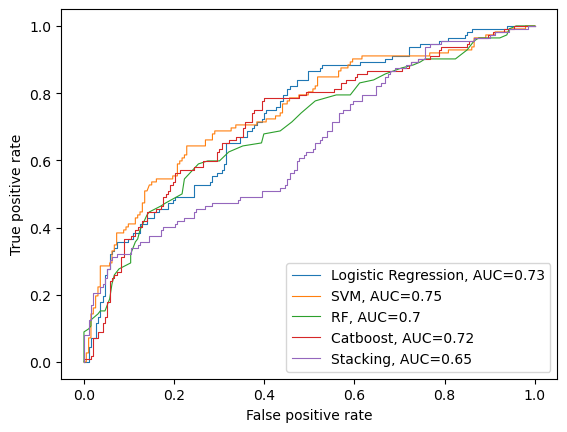

In [54]:
plt.figure(0).clf()
plt.plot(fpr_lr, tpr_lr, label="Logistic Regression, AUC=" + str(roc_auc_lr), linewidth=0.8)
# plt.plot(fpr_xgb, tpr_xgb, label="XGB, AUC=" + str(roc_auc_xgb), linewidth=0.8)
plt.plot(fpr_svm, tpr_svm, label="SVM, AUC=" + str(roc_auc_svm), linewidth=0.8)
plt.plot(fpr_rf, tpr_rf, label="RF, AUC=" + str(roc_auc_rf), linewidth=0.8)
plt.plot(fpr_cat, tpr_cat, label="Catboost, AUC=" + str(roc_auc_cat), linewidth=0.8)
# plt.plot(fpr_lgbm, tpr_lgbm, label="LightGBM, AUC=" + str(roc_auc_lgbm), linewidth=0.8)
# plt.plot(fpr_et, tpr_et, label="ExtraTrees, AUC=" + str(roc_auc_et), linewidth=0.8)
plt.plot(fpr_stack, tpr_stack, label="Stacking, AUC=" + str(roc_auc_stack), linewidth=0.8)
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.savefig('../images/Report/roc_avg.pdf', bbox_inches='tight');